In [280]:
# %matplotlib inline
import warnings
import re
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from fbprophet import Prophet
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

from preprocessing import TargetLagsFeaturizer, MeanTimeDataResampler, FeaturesDropper

In [162]:
# CONFIG
DATE_COLUMN = 'ds' # date column name compatible with fbprophet
TARGET_COLUMN = 'y' # target column name compatible with fbprophet
MIN_LAG, MAX_LAG = 13, 22 # minimum and maximum lags (in weeks) of target to include as features
DAYS_IN_WEEK = 7
MONTHS_IN_YEAR = 12
SPLITS = 5 # number of splits in time series cross-validation
FIRST_SPLIT_TO_INCLUDE = 2 # first split whose result will be included in CV result (starting from 0)
MAX_PLACE_VALUE = 51 # value, for which zeros will be replaced
PROBS = [0.1, 0.25, 0.5, 0.75] # percentiles for tags places data

## Read data into memory

In [163]:
# read main dataset into memory
df = pd.read_csv('data/HME020030N.csv', parse_dates=[0])
# rename date and target column for names compatible with fbprophet
df.columns = [DATE_COLUMN] + df.columns.to_list()[1:-1] + [TARGET_COLUMN]
# retrieve tags names
TAGS=list(df)[66:116]

In [164]:
# read dataset with tags places into memory
df_tags_raw = pd.read_csv("data/HME020030N_ranks.tsv", sep='\t', header=None, 
                          names=['name', DATE_COLUMN, 'tag',  'place'],
                          parse_dates=[1])
df_tags_raw['place'] = df_tags_raw['place'].apply(lambda x: x if x else MAX_PLACE_VALUE)

## Build preprocessing pipeline

In [293]:
preprocessor = Pipeline([
    ('droping_features', FeaturesDropper(['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear'] + TAGS)),
    ('resample_by_week', MeanTimeDataResampler(freq='1W')),
#     ('add_lags', TargetLagsFeaturizer(start_lag=MIN_LAG, end_lag=MAX_LAG))
])
#preprocess input data
df_prep = preprocessor.fit_transform(df)

In [240]:
df_prep.head()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,dehumidifiers_trend,30 pint dehumidifier_ara,30 pint dehumidifier_trend,air purifier_ara,air purifier_trend,dehumidifiers for basements_ara,dehumidifiers for basements_trend,dehumidifier 70 pint_ara,dehumidifier 70 pint_trend,dehumidifier for bathroom_ara,dehumidifier for bathroom_trend,small dehumidifier_ara,small dehumidifier_trend,50 pint dehumidifier_ara,50 pint dehumidifier_trend,dehumidifier small_ara,dehumidifier small_trend,dehumidifier with drain hose_ara,dehumidifier with drain hose_trend,70 pint dehumidifier_ara,70 pint dehumidifier_trend,closet dehumidifier_ara,closet dehumidifier_trend,safe dehumidifier_ara,safe dehumidifier_trend,dehumidifier air purifier_ara,dehumidifier air purifier_trend,dehumidifier for basements_ara,dehumidifier for basements_trend,bathroom dehumidifier_ara,bathroom dehumidifier_trend,basement dehumidifier_ara,basement dehumidifier_trend,whole house dehumidifier_ara,whole house dehumidifier_trend,portable dehumidifier_ara,portable dehumidifier_trend,dehumidifier for rv_ara,dehumidifier for rv_trend,dehumidifier hose_ara,dehumidifier hose_trend,inventory_fbm,inventory_fba,phase_Sustain_SoldOut,phase_Sustain,AVGSalePrice,Holiday_Christmas Day,Holiday_Columbus Day,Holiday_Independence Day,Holiday_Labor Day,Holiday_Martin Luther King Jr. Day,Holiday_Memorial Day,Holiday_New Year Day,Holiday_Presidents Day (Washingtons Birthday),Holiday_Thanksgiving Day,Holiday_Veterans Day,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,y
0,2017-07-16,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22.0,47186.0,26.875,170428.0,81.25,21663.0,17.875,163749.0,23.125,146125.0,41.875,298290.0,60.25,212112.0,18.125,371757.0,49.375,-47796.5,38.875,0.410084,0.033696,0.0,0.0,144.990000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0,41.166667
1,2017-07-23,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22.0,47186.0,26.875,170428.0,81.25,21663.0,17.875,163749.0,23.125,146125.0,41.875,298290.0,60.25,212112.0,18.125,371757.0,49.375,-47796.5,38.875,0.410084,0.033696,0.0,0.0,148.392560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.000000,0.000000,0.0,0.0,0.0,0.0,58.857143
2,2017-07-30,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22.0,47186.0,26.875,170428.0,81.25,21663.0,17.875,163749.0,23.125,146125.0,41.875,298290.0,60.25,212112.0,18.125,371757.0,49.375,-47796.5,38.875,0.410084,0.033696,0.0,0.0,200.097932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.000000,0.000000,0.0,0.0,0.0,0.0,58.571429
3,2017-08-06,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22.0,47186.0,26.875,170428.0,81.25,21663.0,17.875,163749.0,23.125,146125.0,41.875,298290.0,60.25,212112.0,18.125,371757.0,49.375,-47796.5,38.875,0.410084,0.033696,0.0,0.0,213.871992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.142857,0.142857,0.0,0.0,0.0,0.0,77.571429
4,2017-08-13,14790.0,29.0,389.5,56.625,8462.0,33.875,80363.0,48.0,8392.0,52.125,123508.0,49.625,-268.0,51.0,1177.0,15.375,24108.5,44.375,54927.5,25.375,86582.0,55.75,122069.5,29.0,303608.5,60.625,114815.5,17.625,31603.5,37.875,80672.5,22

### Transform tags places into weekly distributions

In [189]:
def percentile(d, probs):
    """Calculate probs percentiles of dict d keys according to d values"""
    sorted_keys = sorted(d.keys())
    sorted_values = [d[k] for k in sorted_keys]
    b = np.cumsum(sorted_values) / np.sum(sorted_values)
    return {k: sorted_keys[len(b[b <= k])] for k in probs}

In [190]:
# get weeks ends
dates = np.array(df_prep[DATE_COLUMN])
# get start of the first week
first_start = dates[0] - np.timedelta64(DAYS_IN_WEEK, 'D')

In [191]:
# calculate duration of tags places
places = defaultdict(lambda: defaultdict(list))
for tag in tqdm(TAGS):
    print(f'[INFO] Processing data for tag "{tag}"')
    # select rows corresponding to tag
    df_tag = df_tags_raw.loc[df_tags_raw.tag == tag]
    for start_, finish_ in zip(np.insert(dates[:-1], 0, first_start), dates):
        start = start_ + np.timedelta64(1, 'D')
        finish = finish_ + np.timedelta64(1, 'D')
        # select row corresponding to particular week
        df_tag_time = df_tag.loc[(df_tags_raw.ds > start) & (df_tags_raw.ds <= finish)]
        last_ds = start
        for i, row in df_tag_time.iterrows():
            curr_ds = row.ds.to_datetime64()
            if not places[tag][finish_]: # if duration list is empty look at previous week
                place = places[tag][start_][-1][-1] if start in places[tag] else MAX_PLACE_VALUE # if no previous week, set place to 0
            else:
                place = last_place
            places[tag][finish_].append((curr_ds - last_ds, place))
            last_ds, last_place = curr_ds, row.place
        places[tag][finish_].append((finish - last_ds, last_place))
for tag, tag_info in places.items():
    for date, date_info in tag_info.items():
        date_info_dict = defaultdict(int)
        for duration, place in date_info:
            date_info_dict[place] += int(duration)
        tag_info[date] = percentile(date_info_dict, probs=PROBS)

Processing data for tag "dehumidifier 50 pint"
Processing data for tag "dehumidifier"
Processing data for tag "dehumidifiers for home"
Processing data for tag "dehumidifier 30 pint"
Processing data for tag "dehumidifiers"
Processing data for tag "30 pint dehumidifier"
Processing data for tag "air purifier"
Processing data for tag "dehumidifiers for basements"
Processing data for tag "dehumidifier 70 pint"
Processing data for tag "dehumidifier for bathroom"
Processing data for tag "small dehumidifier"
Processing data for tag "compact dehumidifier"
Processing data for tag "energy efficient dehumidifier"
Processing data for tag "50 pint dehumidifier"
Processing data for tag "dehumidifier small"
Processing data for tag "dehumidifier with drain hose"
Processing data for tag "home dehumidifier"
Processing data for tag "70 pint dehumidifier"
Processing data for tag "dehumidifier for safe"
Processing data for tag "closet dehumidifier"
Processing data for tag "dehumidifier for home"
Processing 

In [192]:
# transform duration data in DataFrame with percentiles
index = list(places[TAGS[0]].keys())
data = defaultdict(list)
for tag, tag_info in tqdm(places.items()):
    for date, date_info in tag_info.items():
        data[date].extend(list(date_info.values()))
cols = [f'{col}_{prob}' for col in places.keys() for prob in PROBS]
df_tags = pd.DataFrame.from_dict(data=data, orient='index', columns=cols).reset_index()
df_tags.columns = [DATE_COLUMN] + df_tags.columns.to_list()[1:]

### Concatenate main dataset with preprocessed tags places data and split for train/test sets

In [294]:
# concatenate preprocess features with tags features
df_prep = pd.merge(df_prep, df_tags, on=DATE_COLUMN)
df_prep[[TARGET_COLUMN]] = df_prep[TARGET_COLUMN] * DAYS_IN_WEEK

# split data on train/validation/test set
df_train, df_test = df_prep.loc[~df_prep[TARGET_COLUMN].isnull()], df_prep.loc[df_prep[TARGET_COLUMN].isnull()]
X_train, y_train = df_train.drop(columns=[TARGET_COLUMN]), df_train[[DATE_COLUMN, TARGET_COLUMN]].set_index(DATE_COLUMN)
X_train.shape, y_train.shape

((103, 273), (103, 1))

In [194]:
X_train.head()

,ds,dehumidifier 50 pint_ara,dehumidifier 50 pint_trend,dehumidifier_ara,dehumidifier_trend,dehumidifiers for home_ara,dehumidifiers for home_trend,dehumidifier 30 pint_ara,dehumidifier 30 pint_trend,dehumidifiers_ara,dehumidifiers_trend,30 pint dehumidifier_ara,30 pint dehumidifier_trend,air purifier_ara,air purifier_trend,dehumidifiers for basements_ara,dehumidifiers for basements_trend,dehumidifier 70 pint_ara,dehumidifier 70 pint_trend,dehumidifier for bathroom_ara,dehumidifier for bathroom_trend,small dehumidifier_ara,small dehumidifier_trend,50 pint dehumidifier_ara,50 pint dehumidifier_trend,dehumidifier small_ara,dehumidifier small_trend,dehumidifier with drain hose_ara,dehumidifier with drain hose_trend,70 pint dehumidifier_ara,70 pint dehumidifier_trend,closet dehumidifier_ara,closet dehumidifier_trend,safe dehumidifier_ara,safe dehumidifier_trend,dehumidifier air purifier_ara,dehumidifier air purifier_trend,dehumidifier for basements_ara,dehumidifier for basements_trend,bathroom dehumidifier_ara,bathroom dehumidifier_trend,basement dehumidifier_ara,basement dehumidifier_trend,whole house dehumidifier_ara,whole house dehumidifier_trend,portable dehumidifier_ara,portable dehumidifier_trend,dehumidifier for rv_ara,dehumidifier for rv_trend,dehumidifier hose_ara,dehumidifier hose_trend,inventory_fbm,inventory_fba,phase_Sustain_SoldOut,phase_Sustain,AVGSalePrice,Holiday_Christmas Day,Holiday_Columbus Day,Holiday_Independence Day,Holiday_Labor Day,Holiday_Martin Luther King Jr. Day,Holiday_Memorial Day,Holiday_New Year Day,Holiday_Presidents Day (Washingtons Birthday),Holiday_Thanksgiving Day,Holiday_Veterans Day,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,dehumidifier 50 pint_0.1,dehumidifier 50 pint_0.25,dehumidifier 50 pint_0.5,dehumidifier 50 pint_0.75,dehumidifier_0.1,dehumidifier_0.25,dehumidifier_0.5,dehumidifier_0.75,dehumidifiers for home_0.1,dehumidifiers for home_0.25,dehumidifiers for home_0.5,dehumidifiers for home_0.75,dehumidifier 30 pint_0.1,dehumidifier 30 pint_0.25,dehumidifier 30 pint_0.5,dehumidifier 30 pint_0.75,dehumidifiers_0.1,dehumidifiers_0.25,dehumidifiers_0.5,dehumidifiers_0.75,30 pint dehumidifier_0.1,30 pint dehumidifier_0.25,30 pint dehumidifier_0.5,30 pint dehumidifier_0.75,air purifier_0.1,air purifier_0.25,air purifier_0.5,air purifier_0.75,dehumidifiers for basements_0.1,dehumidifiers for basements_0.25,dehumidifiers for basements_0.5,dehumidifiers for basements_0.75,dehumidifier 70 pint_0.1,dehumidifier 70 pint_0.25,dehumidifier 70 pint_0.5,dehumidifier 70 pint_0.75,dehumidifier for bathroom_0.1,dehumidifier for bathroom_0.25,dehumidifier for bathroom_0.5,dehumidifier for bathroom_0.75,small dehumidifier_0.1,small dehumidifier_0.25,small dehumidifier_0.5,small dehumidifier_0.75,compact dehumidifier_0.1,compact dehumidifier_0.25,compact dehumidifier_0.5,compact dehumidifier_0.75,energy efficient dehumidifier_0.1,energy efficient dehumidifier_0.25,energy efficient dehumidifier_0.5,energy efficient dehumidifier_0.75,50 pint dehumidifier_0.1,50 pint dehumidifier_0.25,50 pint dehumidifier_0.5,50 pint dehumidifier_0.75,dehumidifier small_0.1,dehumidifier small_0.25,dehumidifier small_0.5,dehumidifier small_0.75,dehumidifier with drain hose_0.1,dehumidifier with drain hose_0.25,dehumidifier with drain hose_0.5,dehumidifier with drain hose_0.75,home dehumidifier_0.1,home dehumidifier_0.25,home dehumidifier_0.5,home dehumidifier_0.75,70 pint dehumidifier_0.1,70 pint dehumidifier_0.25,70 pint dehumidifier_0.5,70 pint dehumidifier_0.75,dehumidifier for safe_0.1,dehumidifier for safe_0.25,dehumidifier for safe_0.5,dehumidifier for safe_0.75,closet dehumidifier_0.1,closet dehumidifier_0.25,closet dehumidifier_0.5,closet dehumidifier_0.75,dehumidifier for home_0.1,dehumidifier for home_0.25,dehumidifier for home_0.5,dehumidifier for home_0.75,dehumidifiers with pump_0.1,dehumidifiers with pump_0.25,dehumidifiers with pump_0.5,dehumidifiers with pump_0.75

### Power transform target value to make its distribution look more normal

Text(0.5, 1.0, 'y_train_transformed')

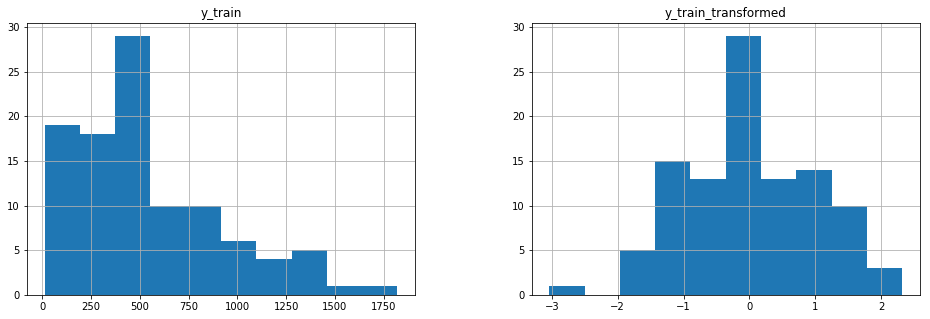

In [195]:
# power transform targets
pt = PowerTransformer()
pt.fit(y_train)
y_train_transformed = pd.DataFrame({DATE_COLUMN:y_train.index, 
                                    TARGET_COLUMN:pt.transform(y_train).squeeze()}
                                   ).set_index(DATE_COLUMN)
# plot results
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,2,1)
y_train.hist(ax=ax1)
ax1.set_title('y_train')
ax2 = fig.add_subplot(1,2,2)
y_train_transformed.hist(ax=ax2)
ax2.set_title('y_train_transformed')

# Training XGBRegressor

In [219]:
class ProphetFeaturizer(TransformerMixin, BaseEstimator):
    """Add seasonality and trend features to initial data using Prophet"""
    def __init__(self, yearly_seasonality=3):
        self.yearly_seasonality = yearly_seasonality
        
    def fit(self, X, y=None):
        if y is not None:
            self.prophet = Prophet(yearly_seasonality=self.yearly_seasonality)
            self.prophet.fit(y.reset_index())
        return self
        
    def transform(self, X):
        forecast = self.prophet.predict(X)
        self.forecast = forecast
        return pd.merge(X, forecast[[DATE_COLUMN, 'yearly']], on=DATE_COLUMN)

### MAPE evaluation

In [220]:
def monthly_resample(s):
    """Resample weekly data by monthes"""
    resampled = defaultdict(list)
    for date in s.index:
        if date.day < DAYS_IN_WEEK:
            days_in_prev_month = DAYS_IN_WEEK - date.day
            prev_month = date.month - 1 if date.month != 1 else MONTHS_IN_YEAR
            prev_year = date.year if date.month != 1 else date.year-1
            resampled['{}-{}-{}'.format(prev_year, prev_month, 1)].append(
                (s.loc[date][TARGET_COLUMN], days_in_prev_month))
        resampled['{}-{}-{}'.format(date.year, date.month, 1)].append(
                 (s.loc[date][TARGET_COLUMN], DAYS_IN_WEEK if date.day // DAYS_IN_WEEK else date.day))
        
    for k, v in resampled.items():
        days_included, target_sum = 0, 0
        for target, days_to_include in v:
            target_sum += target * days_to_include / DAYS_IN_WEEK
            days_included += days_to_include
        resampled[k] = target_sum / days_included * pd.Period(k).days_in_month
    
    resampled = pd.DataFrame(data={DATE_COLUMN: list(resampled.keys()), 
                                   TARGET_COLUMN: list(resampled.values())}
                            )
    resampled[DATE_COLUMN] = pd.to_datetime(resampled[DATE_COLUMN])
    return resampled.set_index(DATE_COLUMN)

In [222]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates MAPE on inverse transformation of predictions
    Also resamples input data by month
    """
    index = y_true.index

    y_true, y_pred = pt.inverse_transform(np.array(y_true)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))
    y_true = pd.DataFrame(data=y_true.reshape(-1, 1), index=index, columns=[TARGET_COLUMN])
    y_pred = pd.DataFrame(data=y_pred.reshape(-1, 1), index=index, columns=[TARGET_COLUMN])
    y_true, y_pred = monthly_resample(y_true), monthly_resample(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_scorer = make_scorer(mean_absolute_percentage_error)

## Hyperparameters optimization with hyperopt

In [223]:
from hyperopt import hp, fmin, tpe, STATUS_OK

In [224]:
BOOSTER = 'dart'
def objective(space):
    prophet = ProphetFeaturizer(yearly_seasonality=3)

    reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1,
                           booster=BOOSTER,
                           max_depth = int(space['xgb__max_depth']),
                           min_child_weight = int(space['xgb__min_child_weight']),
                           subsample = space['xgb__subsample'],
                           colsample_bytree=space['xgb__colsample_bytree'],
                           learning_rate=space['xgb__learning_rate'],
                           n_estimators=int(space['xgb__n_estimators']),
                           gamma=space['xgb__gamma'],
                           reg_alpha=space['xgb__reg_alpha'],
                           reg_lambda=space['xgb__reg_lambda'],

                          )
    
    reg_pipe = Pipeline([
        ('prophet', prophet),
        ('droping_features', FeaturesDropper([DATE_COLUMN])),
        ('xgb', reg)
    ])
    
    tscv = TimeSeriesSplit(n_splits=SPLITS)
    mape = cross_val_score(reg_pipe, X_train, y_train_transformed, cv=tscv, scoring=mape_scorer, n_jobs=-1)
    avg_mape = mape[FIRST_SPLIT_TO_INCLUDE:].mean()
    print("SCORE:", avg_mape)

    return{'loss': avg_mape, 'status': STATUS_OK }

In [225]:
# define space where to look for optimal hparams
space ={'xgb__n_estimators': hp.quniform("xgb__n_estimators", 5, 100, 1),
        'xgb__max_depth': hp.quniform("xgb__max_depth", 2, 10, 1),
        'xgb__min_child_weight': hp.quniform ('xgb__min_child_weight', 1, 10, 1),
        'xgb__subsample': hp.uniform ('xgb__subsample', 0.8, 1),
        'xgb__colsample_bytree': hp.uniform ('xgb__colsample_bytree', 0.5, 1),
        'xgb__learning_rate': hp.uniform ('xgb__learning_rate', 0.05, 0.15),
        'xgb__gamma': hp.uniform('xgb__gamma', 0, 0.3),
        'xgb__reg_alpha': hp.loguniform('xgb__reg_alpha', np.log(1e-5), np.log(10)),
        'xgb__reg_lambda':  hp.loguniform('xgb__reg_lambda', np.log(1e-5), np.log(10)),
       }

In [226]:
OPTIMIZATION_STEPS = 50
best_hparams = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=OPTIMIZATION_STEPS)

  0%|                                                                             | 0/50 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


SCORE:                                                                                                                 
51.45674377515786                                                                                                      
  2%|█                                                    | 1/50 [00:09<07:40,  9.39s/it, best loss: 51.45674377515786]

INFO:hyperopt.tpe:tpe_transform took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 51.456744


SCORE:                                                                                                                 
46.403403576368426                                                                                                     
  4%|██                                                  | 2/50 [00:19<07:35,  9.48s/it, best loss: 46.403403576368426]

INFO:hyperopt.tpe:tpe_transform took 0.003066 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 46.403404


SCORE:                                                                                                                 
43.449034098718066                                                                                                     
  6%|███                                                 | 3/50 [00:26<06:57,  8.88s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 43.449034


SCORE:                                                                                                                 
44.30214712867815                                                                                                      
  8%|████▏                                               | 4/50 [00:30<05:44,  7.49s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 43.449034


SCORE:                                                                                                                 
47.72107699797477                                                                                                      
 10%|█████▏                                              | 5/50 [00:35<04:59,  6.65s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 43.449034


SCORE:                                                                                                                 
45.35845280222393                                                                                                      
 12%|██████▏                                             | 6/50 [00:40<04:26,  6.05s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 43.449034


SCORE:                                                                                                                 
46.83841582069146                                                                                                      
 14%|███████▎                                            | 7/50 [00:44<03:58,  5.54s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 43.449034


SCORE:                                                                                                                 
46.292625168752586                                                                                                     
 16%|████████▎                                           | 8/50 [00:49<03:41,  5.27s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 43.449034


SCORE:                                                                                                                 
51.671629896197906                                                                                                     
 18%|█████████▎                                          | 9/50 [00:53<03:25,  5.01s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.002028 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 43.449034


SCORE:                                                                                                                 
57.324598211048944                                                                                                     
 20%|██████████▏                                        | 10/50 [00:58<03:14,  4.86s/it, best loss: 43.449034098718066]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 43.449034


SCORE:                                                                                                                 
43.00801213389145                                                                                                      
 22%|███████████▍                                        | 11/50 [01:02<03:08,  4.84s/it, best loss: 43.00801213389145]

INFO:hyperopt.tpe:tpe_transform took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 43.008012


SCORE:                                                                                                                 
52.137616987518186                                                                                                     
 24%|████████████▍                                       | 12/50 [01:07<03:02,  4.81s/it, best loss: 43.00801213389145]

INFO:hyperopt.tpe:tpe_transform took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 43.008012


SCORE:                                                                                                                 
48.27543068735449                                                                                                      
 26%|█████████████▌                                      | 13/50 [01:12<02:55,  4.75s/it, best loss: 43.00801213389145]

INFO:hyperopt.tpe:tpe_transform took 0.003063 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 43.008012


SCORE:                                                                                                                 
43.188919269355274                                                                                                     
 28%|██████████████▌                                     | 14/50 [01:16<02:48,  4.68s/it, best loss: 43.00801213389145]

INFO:hyperopt.tpe:tpe_transform took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 43.008012


SCORE:                                                                                                                 
53.744957267702006                                                                                                     
 30%|███████████████▌                                    | 15/50 [01:21<02:42,  4.65s/it, best loss: 43.00801213389145]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 43.008012


SCORE:                                                                                                                 
41.021175964081095                                                                                                     
 32%|████████████████▎                                  | 16/50 [01:25<02:36,  4.61s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002005 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 41.021176


SCORE:                                                                                                                 
50.520206836566956                                                                                                     
 34%|█████████████████▎                                 | 17/50 [01:30<02:32,  4.61s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.003039 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 41.021176


SCORE:                                                                                                                 
48.81639629210398                                                                                                      
 36%|██████████████████▎                                | 18/50 [01:34<02:26,  4.59s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 41.021176


SCORE:                                                                                                                 
51.84885253412466                                                                                                      
 38%|███████████████████▍                               | 19/50 [01:39<02:22,  4.58s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 41.021176


SCORE:                                                                                                                 
51.5104671719196                                                                                                       
 40%|████████████████████▍                              | 20/50 [01:43<02:15,  4.52s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002040 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 41.021176


SCORE:                                                                                                                 
51.720463900922624                                                                                                     
 42%|█████████████████████▍                             | 21/50 [01:48<02:10,  4.50s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.003042 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 41.021176


SCORE:                                                                                                                 
45.07456002885582                                                                                                      
 44%|██████████████████████▍                            | 22/50 [01:52<02:04,  4.46s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 41.021176


SCORE:                                                                                                                 
61.26200865217199                                                                                                      
 46%|███████████████████████▍                           | 23/50 [01:57<02:00,  4.48s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002963 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 41.021176


SCORE:                                                                                                                 
44.199195209706396                                                                                                     
 48%|████████████████████████▍                          | 24/50 [02:01<01:56,  4.49s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 41.021176


SCORE:                                                                                                                 
47.52145293600617                                                                                                      
 50%|█████████████████████████▌                         | 25/50 [02:06<01:51,  4.48s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 41.021176


SCORE:                                                                                                                 
42.89174747052036                                                                                                      
 52%|██████████████████████████▌                        | 26/50 [02:10<01:48,  4.52s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 41.021176


SCORE:                                                                                                                 
44.99235150416442                                                                                                      
 54%|███████████████████████████▌                       | 27/50 [02:15<01:46,  4.64s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 41.021176


SCORE:                                                                                                                 
41.20742790795559                                                                                                      
 56%|████████████████████████████▌                      | 28/50 [02:20<01:43,  4.73s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 41.021176


SCORE:                                                                                                                 
44.45476401197735                                                                                                      
 58%|█████████████████████████████▌                     | 29/50 [02:25<01:36,  4.61s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 41.021176


SCORE:                                                                                                                 
49.12496156548261                                                                                                      
 60%|██████████████████████████████▌                    | 30/50 [02:29<01:31,  4.55s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 41.021176


SCORE:                                                                                                                 
47.51101249622758                                                                                                      
 62%|███████████████████████████████▌                   | 31/50 [02:33<01:24,  4.45s/it, best loss: 41.021175964081095]

INFO:hyperopt.tpe:tpe_transform took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 41.021176


SCORE:                                                                                                                 
38.69507124246844                                                                                                      
 64%|█████████████████████████████████▎                  | 32/50 [02:37<01:19,  4.41s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 38.695071


SCORE:                                                                                                                 
44.044262946284455                                                                                                     
 66%|██████████████████████████████████▎                 | 33/50 [02:42<01:14,  4.39s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002043 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 38.695071


SCORE:                                                                                                                 
43.298714759088774                                                                                                     
 68%|███████████████████████████████████▎                | 34/50 [02:46<01:09,  4.37s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 38.695071


SCORE:                                                                                                                 
46.16171187464667                                                                                                      
 70%|████████████████████████████████████▍               | 35/50 [02:50<01:05,  4.35s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 38.695071


SCORE:                                                                                                                 
44.82502267680845                                                                                                      
 72%|█████████████████████████████████████▍              | 36/50 [02:55<01:01,  4.36s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.003068 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 38.695071


SCORE:                                                                                                                 
45.38801961033848                                                                                                      
 74%|██████████████████████████████████████▍             | 37/50 [02:59<00:56,  4.33s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 38.695071


SCORE:                                                                                                                 
44.049952085679074                                                                                                     
 76%|███████████████████████████████████████▌            | 38/50 [03:03<00:51,  4.32s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 38.695071


SCORE:                                                                                                                 
50.56266204574255                                                                                                      
 78%|████████████████████████████████████████▌           | 39/50 [03:08<00:47,  4.35s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001967 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 38.695071


SCORE:                                                                                                                 
45.932572361993614                                                                                                     
 80%|█████████████████████████████████████████▌          | 40/50 [03:12<00:43,  4.32s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss 38.695071


SCORE:                                                                                                                 
44.115613198462086                                                                                                     
 82%|██████████████████████████████████████████▋         | 41/50 [03:16<00:38,  4.32s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss 38.695071


SCORE:                                                                                                                 
44.93484250547033                                                                                                      
 84%|███████████████████████████████████████████▋        | 42/50 [03:21<00:35,  4.46s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.003004 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss 38.695071


SCORE:                                                                                                                 
47.28538309102567                                                                                                      
 86%|████████████████████████████████████████████▋       | 43/50 [03:26<00:32,  4.59s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.004003 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss 38.695071


SCORE:                                                                                                                 
48.81219001088613                                                                                                      
 88%|█████████████████████████████████████████████▊      | 44/50 [03:31<00:27,  4.66s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss 38.695071


SCORE:                                                                                                                 
46.966353285510486                                                                                                     
 90%|██████████████████████████████████████████████▊     | 45/50 [03:35<00:22,  4.60s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002992 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss 38.695071


SCORE:                                                                                                                 
55.554917544338224                                                                                                     
 92%|███████████████████████████████████████████████▊    | 46/50 [03:40<00:18,  4.56s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss 38.695071


SCORE:                                                                                                                 
47.25598661167061                                                                                                      
 94%|████████████████████████████████████████████████▉   | 47/50 [03:44<00:13,  4.51s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss 38.695071


SCORE:                                                                                                                 
52.388501551251835                                                                                                     
 96%|█████████████████████████████████████████████████▉  | 48/50 [03:48<00:08,  4.42s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.001996 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss 38.695071


SCORE:                                                                                                                 
44.21141477136565                                                                                                      
 98%|██████████████████████████████████████████████████▉ | 49/50 [03:53<00:04,  4.43s/it, best loss: 38.69507124246844]

INFO:hyperopt.tpe:tpe_transform took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss 38.695071


SCORE:                                                                                                                 
44.15588252812677                                                                                                      
100%|████████████████████████████████████████████████████| 50/50 [03:58<00:00,  4.55s/it, best loss: 38.69507124246844]


In [227]:
best_hparams = {k: int(v) if int(v) == v else v 
                for k, v in best_hparams.items()}
best_hparams 

{'xgb__colsample_bytree': 0.9852794826083794,
 'xgb__gamma': 0.27907796296155774,
 'xgb__learning_rate': 0.0500659030086694,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 9,
 'xgb__n_estimators': 50,
 'xgb__reg_alpha': 4.078768474035196,
 'xgb__reg_lambda': 0.0002007343540626582,
 'xgb__subsample': 0.9824525131881051}

### Visualize predictions of best estimator on CV splits

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override th

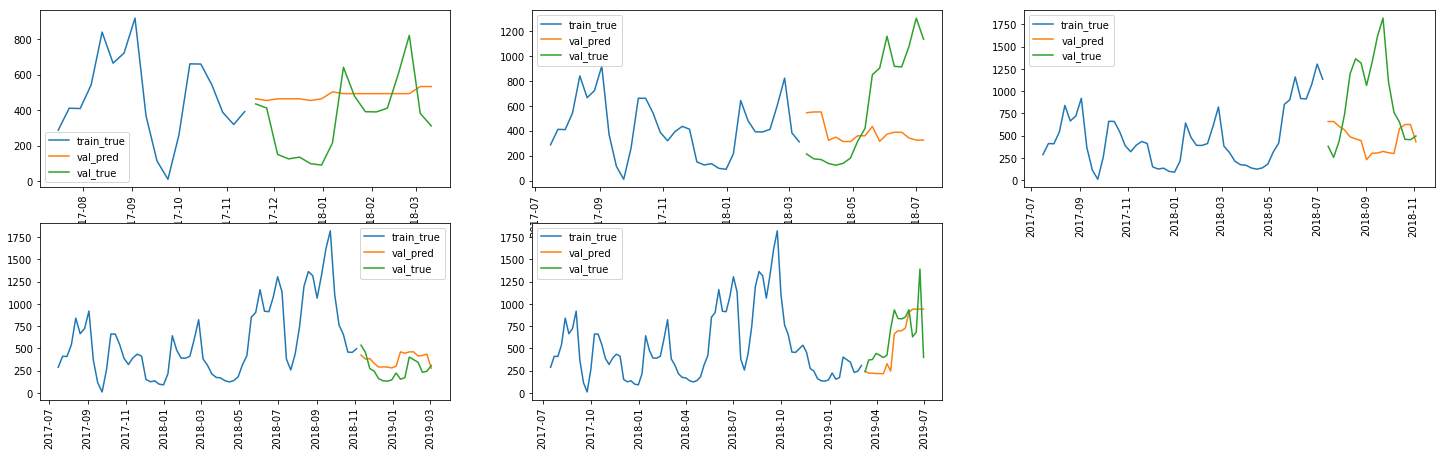

In [233]:
h, w = 4, 3
tscv = TimeSeriesSplit(n_splits=SPLITS)
fig = plt.figure(figsize=(25, 15))
for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
    train = X_train.iloc[train_index]
    valid = X_train.iloc[val_index]
    
    estim_pipeline = Pipeline([
        ('prophet', ProphetFeaturizer()),
        ('droping_features', FeaturesDropper([DATE_COLUMN])),
        ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1,
                           booster=BOOSTER))
    ])
    estim_pipeline.set_params(**best_hparams)
    estim_pipeline.fit(train, y_train_transformed.iloc[train_index])
    
    pred = estim_pipeline.predict(valid)
    pred = pt.inverse_transform(pred.reshape(-1, 1)).squeeze()
        
    ax = fig.add_subplot(h, w, i+1)
    ax.plot(train['ds'], y_train.iloc[train_index])
    ax.plot(valid['ds'], pred)
    ax.plot(valid['ds'], y_train.iloc[val_index])
    ax.legend(['train_true', 'val_pred', 'val_true'])
    plt.xticks(rotation='vertical')

In [242]:
estim_pipeline = Pipeline([
    ('prophet', ProphetFeaturizer()),
    ('droping_features', FeaturesDropper([DATE_COLUMN])),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1,
                           booster=BOOSTER))
    ])
estim_pipeline.set_params(**best_hparams)
estim_pipeline.fit(X_train, y_train_transformed)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Pipeline(memory=None,
     steps=[('prophet', ProphetFeaturizer(yearly_seasonality=3)), ('droping_features', <preprocessing.FeaturesDropper object at 0x00000293018F4898>), ('xgb', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9852794826083794,
       gamma=0.27...     scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9824525131881051, verbosity=1))])

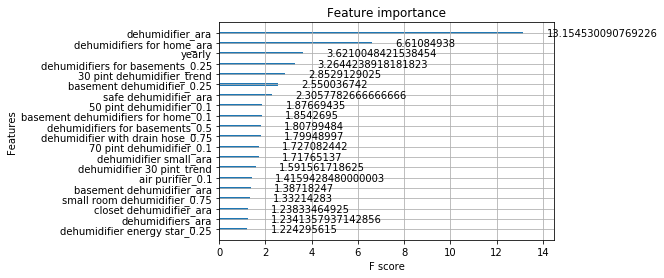

In [318]:
xgb.plot_importance(estim_pipeline.named_steps['xgb'], importance_type='gain', max_num_features=20)

In [319]:
pattern = re.compile(r'^[a-zA-Z0-9 ]+_0\.[1-9]+$')
important_tags = [ x[0] for x in sorted(estim_pipeline.named_steps['xgb']\
                                        .get_booster().get_score(importance_type="gain")\
                                        .items(), key=lambda x: -x[1])[:25] if pattern.match(x[0])
                 ]

In [320]:
important_tags

['dehumidifiers for basements_0.25',
 'basement dehumidifier_0.25',
 '50 pint dehumidifier_0.1',
 'basement dehumidifiers for home_0.1',
 'dehumidifiers for basements_0.5',
 'dehumidifier with drain hose_0.75',
 '70 pint dehumidifier_0.1',
 'air purifier_0.1',
 'small room dehumidifier_0.75',
 'dehumidifier energy star_0.25',
 'closet dehumidifier_0.75']

# Predict for the future

#### Prediction for model with lags included

In [238]:
for i, (index, row) in enumerate(df_test.iterrows()):
    # predict next value for y
    row = df_test.iloc[[i]].drop(columns=[TARGET_COLUMN])
    pred_transformed = estim_pipeline.predict(row)
    pred = pt.inverse_transform(pred_transformed.reshape(-1, 1)).squeeze()

    # fill in lags for future values
    df_test.at[index, TARGET_COLUMN] = pred
    
    for shift in range(MIN_LAG, MAX_LAG + 1):
        if (index + shift) not in df_test.index:
            break
        df_test.at[index+shift, '{}_lag_{}'.format(TARGET_COLUMN, shift)] = pred

ValueError: feature_names mismatch: ['dehumidifier 50 pint_ara', 'dehumidifier 50 pint_trend', 'dehumidifier_ara', 'dehumidifier_trend', 'dehumidifiers for home_ara', 'dehumidifiers for home_trend', 'dehumidifier 30 pint_ara', 'dehumidifier 30 pint_trend', 'dehumidifiers_ara', 'dehumidifiers_trend', '30 pint dehumidifier_ara', '30 pint dehumidifier_trend', 'air purifier_ara', 'air purifier_trend', 'dehumidifiers for basements_ara', 'dehumidifiers for basements_trend', 'dehumidifier 70 pint_ara', 'dehumidifier 70 pint_trend', 'dehumidifier for bathroom_ara', 'dehumidifier for bathroom_trend', 'small dehumidifier_ara', 'small dehumidifier_trend', '50 pint dehumidifier_ara', '50 pint dehumidifier_trend', 'dehumidifier small_ara', 'dehumidifier small_trend', 'dehumidifier with drain hose_ara', 'dehumidifier with drain hose_trend', '70 pint dehumidifier_ara', '70 pint dehumidifier_trend', 'closet dehumidifier_ara', 'closet dehumidifier_trend', 'safe dehumidifier_ara', 'safe dehumidifier_trend', 'dehumidifier air purifier_ara', 'dehumidifier air purifier_trend', 'dehumidifier for basements_ara', 'dehumidifier for basements_trend', 'bathroom dehumidifier_ara', 'bathroom dehumidifier_trend', 'basement dehumidifier_ara', 'basement dehumidifier_trend', 'whole house dehumidifier_ara', 'whole house dehumidifier_trend', 'portable dehumidifier_ara', 'portable dehumidifier_trend', 'dehumidifier for rv_ara', 'dehumidifier for rv_trend', 'dehumidifier hose_ara', 'dehumidifier hose_trend', 'inventory_fbm', 'inventory_fba', 'phase_Sustain_SoldOut', 'phase_Sustain', 'AVGSalePrice', 'Holiday_Christmas Day', 'Holiday_Columbus Day', 'Holiday_Independence Day', 'Holiday_Labor Day', 'Holiday_Martin Luther King Jr. Day', 'Holiday_Memorial Day', 'Holiday_New Year Day', 'Holiday_Presidents Day (Washingtons Birthday)', 'Holiday_Thanksgiving Day', 'Holiday_Veterans Day', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'dehumidifier 50 pint_0.1', 'dehumidifier 50 pint_0.25', 'dehumidifier 50 pint_0.5', 'dehumidifier 50 pint_0.75', 'dehumidifier_0.1', 'dehumidifier_0.25', 'dehumidifier_0.5', 'dehumidifier_0.75', 'dehumidifiers for home_0.1', 'dehumidifiers for home_0.25', 'dehumidifiers for home_0.5', 'dehumidifiers for home_0.75', 'dehumidifier 30 pint_0.1', 'dehumidifier 30 pint_0.25', 'dehumidifier 30 pint_0.5', 'dehumidifier 30 pint_0.75', 'dehumidifiers_0.1', 'dehumidifiers_0.25', 'dehumidifiers_0.5', 'dehumidifiers_0.75', '30 pint dehumidifier_0.1', '30 pint dehumidifier_0.25', '30 pint dehumidifier_0.5', '30 pint dehumidifier_0.75', 'air purifier_0.1', 'air purifier_0.25', 'air purifier_0.5', 'air purifier_0.75', 'dehumidifiers for basements_0.1', 'dehumidifiers for basements_0.25', 'dehumidifiers for basements_0.5', 'dehumidifiers for basements_0.75', 'dehumidifier 70 pint_0.1', 'dehumidifier 70 pint_0.25', 'dehumidifier 70 pint_0.5', 'dehumidifier 70 pint_0.75', 'dehumidifier for bathroom_0.1', 'dehumidifier for bathroom_0.25', 'dehumidifier for bathroom_0.5', 'dehumidifier for bathroom_0.75', 'small dehumidifier_0.1', 'small dehumidifier_0.25', 'small dehumidifier_0.5', 'small dehumidifier_0.75', 'compact dehumidifier_0.1', 'compact dehumidifier_0.25', 'compact dehumidifier_0.5', 'compact dehumidifier_0.75', 'energy efficient dehumidifier_0.1', 'energy efficient dehumidifier_0.25', 'energy efficient dehumidifier_0.5', 'energy efficient dehumidifier_0.75', '50 pint dehumidifier_0.1', '50 pint dehumidifier_0.25', '50 pint dehumidifier_0.5', '50 pint dehumidifier_0.75', 'dehumidifier small_0.1', 'dehumidifier small_0.25', 'dehumidifier small_0.5', 'dehumidifier small_0.75', 'dehumidifier with drain hose_0.1', 'dehumidifier with drain hose_0.25', 'dehumidifier with drain hose_0.5', 'dehumidifier with drain hose_0.75', 'home dehumidifier_0.1', 'home dehumidifier_0.25', 'home dehumidifier_0.5', 'home dehumidifier_0.75', '70 pint dehumidifier_0.1', '70 pint dehumidifier_0.25', '70 pint dehumidifier_0.5', '70 pint dehumidifier_0.75', 'dehumidifier for safe_0.1', 'dehumidifier for safe_0.25', 'dehumidifier for safe_0.5', 'dehumidifier for safe_0.75', 'closet dehumidifier_0.1', 'closet dehumidifier_0.25', 'closet dehumidifier_0.5', 'closet dehumidifier_0.75', 'dehumidifier for home_0.1', 'dehumidifier for home_0.25', 'dehumidifier for home_0.5', 'dehumidifier for home_0.75', 'dehumidifiers with pump_0.1', 'dehumidifiers with pump_0.25', 'dehumidifiers with pump_0.5', 'dehumidifiers with pump_0.75', 'energy star dehumidifier_0.1', 'energy star dehumidifier_0.25', 'energy star dehumidifier_0.5', 'energy star dehumidifier_0.75', 'safe dehumidifier_0.1', 'safe dehumidifier_0.25', 'safe dehumidifier_0.5', 'safe dehumidifier_0.75', 'dehumidifier air purifier_0.1', 'dehumidifier air purifier_0.25', 'dehumidifier air purifier_0.5', 'dehumidifier air purifier_0.75', 'small dehumidifiers for rv_0.1', 'small dehumidifiers for rv_0.25', 'small dehumidifiers for rv_0.5', 'small dehumidifiers for rv_0.75', 'mid size dehumidifier_0.1', 'mid size dehumidifier_0.25', 'mid size dehumidifier_0.5', 'mid size dehumidifier_0.75', 'room dehumidifier_0.1', 'room dehumidifier_0.25', 'room dehumidifier_0.5', 'room dehumidifier_0.75', 'room dehumidifiers for home_0.1', 'room dehumidifiers for home_0.25', 'room dehumidifiers for home_0.5', 'room dehumidifiers for home_0.75', 'small dehumidifiers_0.1', 'small dehumidifiers_0.25', 'small dehumidifiers_0.5', 'small dehumidifiers_0.75', 'dehumidifier for basements_0.1', 'dehumidifier for basements_0.25', 'dehumidifier for basements_0.5', 'dehumidifier for basements_0.75', 'bathroom dehumidifier_0.1', 'bathroom dehumidifier_0.25', 'bathroom dehumidifier_0.5', 'bathroom dehumidifier_0.75', 'dehumidifier 30 pt_0.1', 'dehumidifier 30 pt_0.25', 'dehumidifier 30 pt_0.5', 'dehumidifier 30 pt_0.75', 'dehumidifier for bedroom_0.1', 'dehumidifier for bedroom_0.25', 'dehumidifier for bedroom_0.5', 'dehumidifier for bedroom_0.75', 'dehumidifier for basement_0.1', 'dehumidifier for basement_0.25', 'dehumidifier for basement_0.5', 'dehumidifier for basement_0.75', '30 pint dehumidifiers_0.1', '30 pint dehumidifiers_0.25', '30 pint dehumidifiers_0.5', '30 pint dehumidifiers_0.75', 'basement dehumidifier_0.1', 'basement dehumidifier_0.25', 'basement dehumidifier_0.5', 'basement dehumidifier_0.75', 'basement dehumidifiers for home_0.1', 'basement dehumidifiers for home_0.25', 'basement dehumidifiers for home_0.5', 'basement dehumidifiers for home_0.75', 'whole house dehumidifier_0.1', 'whole house dehumidifier_0.25', 'whole house dehumidifier_0.5', 'whole house dehumidifier_0.75', 'portable dehumidifier_0.1', 'portable dehumidifier_0.25', 'portable dehumidifier_0.5', 'portable dehumidifier_0.75', 'small room dehumidifier_0.1', 'small room dehumidifier_0.25', 'small room dehumidifier_0.5', 'small room dehumidifier_0.75', 'dehumidifier auto shut off_0.1', 'dehumidifier auto shut off_0.25', 'dehumidifier auto shut off_0.5', 'dehumidifier auto shut off_0.75', 'dehumidifier for rv_0.1', 'dehumidifier for rv_0.25', 'dehumidifier for rv_0.5', 'dehumidifier for rv_0.75', 'dehumidifier with hose_0.1', 'dehumidifier with hose_0.25', 'dehumidifier with hose_0.5', 'dehumidifier with hose_0.75', 'dehumidifier with hose drain_0.1', 'dehumidifier with hose drain_0.25', 'dehumidifier with hose drain_0.5', 'dehumidifier with hose drain_0.75', 'crawl space dehumidifier_0.1', 'crawl space dehumidifier_0.25', 'crawl space dehumidifier_0.5', 'crawl space dehumidifier_0.75', 'dehumidifier hose_0.1', 'dehumidifier hose_0.25', 'dehumidifier hose_0.5', 'dehumidifier hose_0.75', 'dehumidifier energy star_0.1', 'dehumidifier energy star_0.25', 'dehumidifier energy star_0.5', 'dehumidifier energy star_0.75', 'small dehumidifier for bathroom_0.1', 'small dehumidifier for bathroom_0.25', 'small dehumidifier for bathroom_0.5', 'small dehumidifier for bathroom_0.75', 'dehumidifier 70_0.1', 'dehumidifier 70_0.25', 'dehumidifier 70_0.5', 'dehumidifier 70_0.75', 'yearly'] ['dehumidifier 50 pint_ara', 'dehumidifier 50 pint_trend', 'dehumidifier_ara', 'dehumidifier_trend', 'dehumidifiers for home_ara', 'dehumidifiers for home_trend', 'dehumidifier 30 pint_ara', 'dehumidifier 30 pint_trend', 'dehumidifiers_ara', 'dehumidifiers_trend', '30 pint dehumidifier_ara', '30 pint dehumidifier_trend', 'air purifier_ara', 'air purifier_trend', 'dehumidifiers for basements_ara', 'dehumidifiers for basements_trend', 'dehumidifier 70 pint_ara', 'dehumidifier 70 pint_trend', 'dehumidifier for bathroom_ara', 'dehumidifier for bathroom_trend', 'small dehumidifier_ara', 'small dehumidifier_trend', '50 pint dehumidifier_ara', '50 pint dehumidifier_trend', 'dehumidifier small_ara', 'dehumidifier small_trend', 'dehumidifier with drain hose_ara', 'dehumidifier with drain hose_trend', '70 pint dehumidifier_ara', '70 pint dehumidifier_trend', 'closet dehumidifier_ara', 'closet dehumidifier_trend', 'safe dehumidifier_ara', 'safe dehumidifier_trend', 'dehumidifier air purifier_ara', 'dehumidifier air purifier_trend', 'dehumidifier for basements_ara', 'dehumidifier for basements_trend', 'bathroom dehumidifier_ara', 'bathroom dehumidifier_trend', 'basement dehumidifier_ara', 'basement dehumidifier_trend', 'whole house dehumidifier_ara', 'whole house dehumidifier_trend', 'portable dehumidifier_ara', 'portable dehumidifier_trend', 'dehumidifier for rv_ara', 'dehumidifier for rv_trend', 'dehumidifier hose_ara', 'dehumidifier hose_trend', 'inventory_fbm', 'inventory_fba', 'phase_Sustain_SoldOut', 'phase_Sustain', 'AVGSalePrice', 'Holiday_Christmas Day', 'Holiday_Columbus Day', 'Holiday_Independence Day', 'Holiday_Labor Day', 'Holiday_Martin Luther King Jr. Day', 'Holiday_Memorial Day', 'Holiday_New Year Day', 'Holiday_Presidents Day (Washingtons Birthday)', 'Holiday_Thanksgiving Day', 'Holiday_Veterans Day', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'dehumidifier 50 pint_0.1', 'dehumidifier 50 pint_0.25', 'dehumidifier 50 pint_0.5', 'dehumidifier 50 pint_0.75', 'dehumidifier_0.1', 'dehumidifier_0.25', 'dehumidifier_0.5', 'dehumidifier_0.75', 'dehumidifiers for home_0.1', 'dehumidifiers for home_0.25', 'dehumidifiers for home_0.5', 'dehumidifiers for home_0.75', 'dehumidifier 30 pint_0.1', 'dehumidifier 30 pint_0.25', 'dehumidifier 30 pint_0.5', 'dehumidifier 30 pint_0.75', 'dehumidifiers_0.1', 'dehumidifiers_0.25', 'dehumidifiers_0.5', 'dehumidifiers_0.75', '30 pint dehumidifier_0.1', '30 pint dehumidifier_0.25', '30 pint dehumidifier_0.5', '30 pint dehumidifier_0.75', 'air purifier_0.1', 'air purifier_0.25', 'air purifier_0.5', 'air purifier_0.75', 'dehumidifiers for basements_0.1', 'dehumidifiers for basements_0.25', 'dehumidifiers for basements_0.5', 'dehumidifiers for basements_0.75', 'dehumidifier 70 pint_0.1', 'dehumidifier 70 pint_0.25', 'dehumidifier 70 pint_0.5', 'dehumidifier 70 pint_0.75', 'dehumidifier for bathroom_0.1', 'dehumidifier for bathroom_0.25', 'dehumidifier for bathroom_0.5', 'dehumidifier for bathroom_0.75', 'small dehumidifier_0.1', 'small dehumidifier_0.25', 'small dehumidifier_0.5', 'small dehumidifier_0.75', 'compact dehumidifier_0.1', 'compact dehumidifier_0.25', 'compact dehumidifier_0.5', 'compact dehumidifier_0.75', 'energy efficient dehumidifier_0.1', 'energy efficient dehumidifier_0.25', 'energy efficient dehumidifier_0.5', 'energy efficient dehumidifier_0.75', '50 pint dehumidifier_0.1', '50 pint dehumidifier_0.25', '50 pint dehumidifier_0.5', '50 pint dehumidifier_0.75', 'dehumidifier small_0.1', 'dehumidifier small_0.25', 'dehumidifier small_0.5', 'dehumidifier small_0.75', 'dehumidifier with drain hose_0.1', 'dehumidifier with drain hose_0.25', 'dehumidifier with drain hose_0.5', 'dehumidifier with drain hose_0.75', 'home dehumidifier_0.1', 'home dehumidifier_0.25', 'home dehumidifier_0.5', 'home dehumidifier_0.75', '70 pint dehumidifier_0.1', '70 pint dehumidifier_0.25', '70 pint dehumidifier_0.5', '70 pint dehumidifier_0.75', 'dehumidifier for safe_0.1', 'dehumidifier for safe_0.25', 'dehumidifier for safe_0.5', 'dehumidifier for safe_0.75', 'closet dehumidifier_0.1', 'closet dehumidifier_0.25', 'closet dehumidifier_0.5', 'closet dehumidifier_0.75', 'dehumidifier for home_0.1', 'dehumidifier for home_0.25', 'dehumidifier for home_0.5', 'dehumidifier for home_0.75', 'dehumidifiers with pump_0.1', 'dehumidifiers with pump_0.25', 'dehumidifiers with pump_0.5', 'dehumidifiers with pump_0.75', 'energy star dehumidifier_0.1', 'energy star dehumidifier_0.25', 'energy star dehumidifier_0.5', 'energy star dehumidifier_0.75', 'safe dehumidifier_0.1', 'safe dehumidifier_0.25', 'safe dehumidifier_0.5', 'safe dehumidifier_0.75', 'dehumidifier air purifier_0.1', 'dehumidifier air purifier_0.25', 'dehumidifier air purifier_0.5', 'dehumidifier air purifier_0.75', 'small dehumidifiers for rv_0.1', 'small dehumidifiers for rv_0.25', 'small dehumidifiers for rv_0.5', 'small dehumidifiers for rv_0.75', 'mid size dehumidifier_0.1', 'mid size dehumidifier_0.25', 'mid size dehumidifier_0.5', 'mid size dehumidifier_0.75', 'room dehumidifier_0.1', 'room dehumidifier_0.25', 'room dehumidifier_0.5', 'room dehumidifier_0.75', 'room dehumidifiers for home_0.1', 'room dehumidifiers for home_0.25', 'room dehumidifiers for home_0.5', 'room dehumidifiers for home_0.75', 'small dehumidifiers_0.1', 'small dehumidifiers_0.25', 'small dehumidifiers_0.5', 'small dehumidifiers_0.75', 'dehumidifier for basements_0.1', 'dehumidifier for basements_0.25', 'dehumidifier for basements_0.5', 'dehumidifier for basements_0.75', 'bathroom dehumidifier_0.1', 'bathroom dehumidifier_0.25', 'bathroom dehumidifier_0.5', 'bathroom dehumidifier_0.75', 'dehumidifier 30 pt_0.1', 'dehumidifier 30 pt_0.25', 'dehumidifier 30 pt_0.5', 'dehumidifier 30 pt_0.75', 'dehumidifier for bedroom_0.1', 'dehumidifier for bedroom_0.25', 'dehumidifier for bedroom_0.5', 'dehumidifier for bedroom_0.75', 'dehumidifier for basement_0.1', 'dehumidifier for basement_0.25', 'dehumidifier for basement_0.5', 'dehumidifier for basement_0.75', '30 pint dehumidifiers_0.1', '30 pint dehumidifiers_0.25', '30 pint dehumidifiers_0.5', '30 pint dehumidifiers_0.75', 'basement dehumidifier_0.1', 'basement dehumidifier_0.25', 'basement dehumidifier_0.5', 'basement dehumidifier_0.75', 'basement dehumidifiers for home_0.1', 'basement dehumidifiers for home_0.25', 'basement dehumidifiers for home_0.5', 'basement dehumidifiers for home_0.75', 'whole house dehumidifier_0.1', 'whole house dehumidifier_0.25', 'whole house dehumidifier_0.5', 'whole house dehumidifier_0.75', 'portable dehumidifier_0.1', 'portable dehumidifier_0.25', 'portable dehumidifier_0.5', 'portable dehumidifier_0.75', 'small room dehumidifier_0.1', 'small room dehumidifier_0.25', 'small room dehumidifier_0.5', 'small room dehumidifier_0.75', 'dehumidifier auto shut off_0.1', 'dehumidifier auto shut off_0.25', 'dehumidifier auto shut off_0.5', 'dehumidifier auto shut off_0.75', 'dehumidifier for rv_0.1', 'dehumidifier for rv_0.25', 'dehumidifier for rv_0.5', 'dehumidifier for rv_0.75', 'dehumidifier with hose_0.1', 'dehumidifier with hose_0.25', 'dehumidifier with hose_0.5', 'dehumidifier with hose_0.75', 'dehumidifier with hose drain_0.1', 'dehumidifier with hose drain_0.25', 'dehumidifier with hose drain_0.5', 'dehumidifier with hose drain_0.75', 'crawl space dehumidifier_0.1', 'crawl space dehumidifier_0.25', 'crawl space dehumidifier_0.5', 'crawl space dehumidifier_0.75', 'dehumidifier hose_0.1', 'dehumidifier hose_0.25', 'dehumidifier hose_0.5', 'dehumidifier hose_0.75', 'dehumidifier energy star_0.1', 'dehumidifier energy star_0.25', 'dehumidifier energy star_0.5', 'dehumidifier energy star_0.75', 'small dehumidifier for bathroom_0.1', 'small dehumidifier for bathroom_0.25', 'small dehumidifier for bathroom_0.5', 'small dehumidifier for bathroom_0.75', 'dehumidifier 70_0.1', 'dehumidifier 70_0.25', 'dehumidifier 70_0.5', 'dehumidifier 70_0.75', 'y_lag_13', 'y_lag_14', 'y_lag_15', 'y_lag_16', 'y_lag_17', 'y_lag_18', 'y_lag_19', 'y_lag_20', 'y_lag_21', 'y_lag_22', 'yearly']
training data did not have the following fields: y_lag_17, y_lag_14, y_lag_20, y_lag_13, y_lag_19, y_lag_15, y_lag_18, y_lag_16, y_lag_22, y_lag_21

In [ ]:
plt.plot(df_train['ds'], df_train['y'])
plt.plot(df_test['ds'], df_test['y'])

plt.xticks(rotation='vertical')
plt.show()

#### Prediction for model w\o lags

In [357]:
pred = estim_pipeline.predict(df_test.drop(columns=[TARGET_COLUMN]))
pred = pt.inverse_transform(pred.reshape(-1, 1)).squeeze()

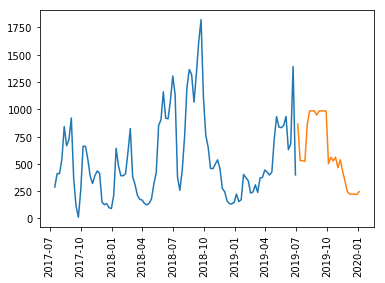

In [358]:
plt.plot(df_train['ds'], df_train['y'])
plt.plot(df_test['ds'], pred)
# plt.plot(df_val['ds'], df_val['y'])

plt.xticks(rotation='vertical')
plt.show()

### Simulating sales until the end of the year

In [355]:
cols_to_change = [f'{col}_{prob}' for col in TAGS for prob in PROBS]
for index, row in tqdm(df_test.iterrows()):
    date = row.ds
    first = df_train.loc[df_train.ds == date - np.timedelta64(52, 'W')]
    for col in cols_to_change:
        df_test.at[index, col] = first.iloc[0].loc[col]

In [359]:
mean_predictions = defaultdict(list)
for tag in tqdm(important_tags):
    print(f'[INFO] Predicting for tag "{tag}"')
    temp = df_test[[tag]]
    for place in range(1, MAX_PLACE_VALUE + 1):
        df_test[[tag]] = place
        pred = estim_pipeline.predict(df_test.drop(columns=[TARGET_COLUMN]))
        pred = pt.inverse_transform(pred.reshape(-1, 1)).squeeze()
        mean_predictions[tag].append(pred.mean())
    df_test[[tag]] = temp

[INFO] Predicting for tag "dehumidifiers for basements_0.25"
[INFO] Predicting for tag "basement dehumidifier_0.25"
[INFO] Predicting for tag "50 pint dehumidifier_0.1"
[INFO] Predicting for tag "basement dehumidifiers for home_0.1"
[INFO] Predicting for tag "dehumidifiers for basements_0.5"
[INFO] Predicting for tag "dehumidifier with drain hose_0.75"
[INFO] Predicting for tag "70 pint dehumidifier_0.1"
[INFO] Predicting for tag "air purifier_0.1"
[INFO] Predicting for tag "small room dehumidifier_0.75"
[INFO] Predicting for tag "dehumidifier energy star_0.25"
[INFO] Predicting for tag "closet dehumidifier_0.75"


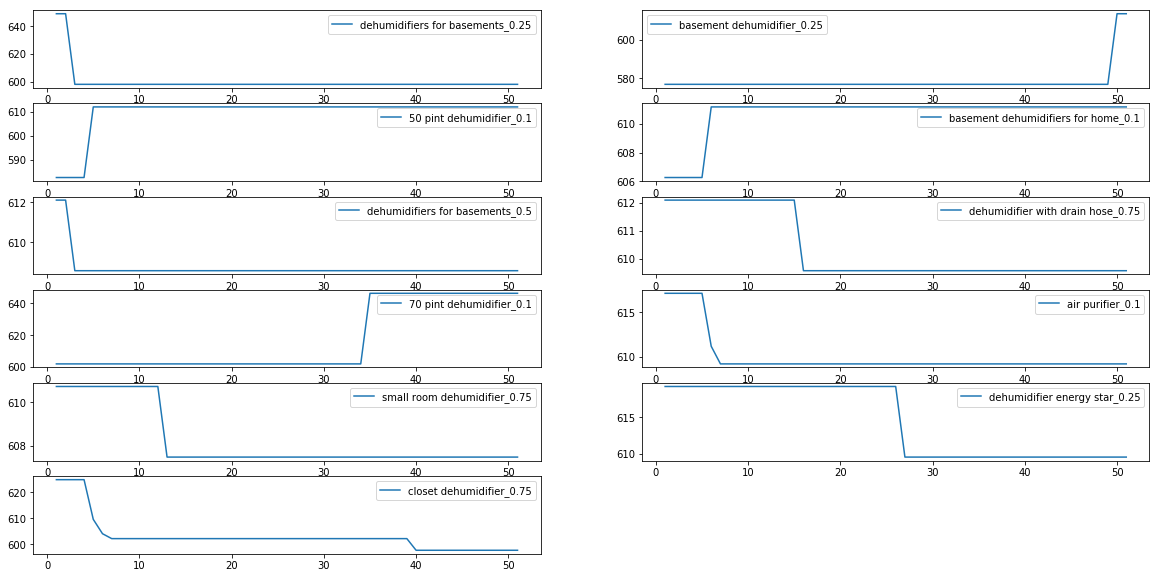

In [361]:
fig = plt.figure(figsize=(20, 10))
for i, preds in enumerate(mean_predictions.values()):
    ax = fig.add_subplot(len(mean_predictions) // 2 + 1, 2, i + 1)
    ax.plot(range(1, MAX_PLACE_VALUE + 1), preds)
    ax.legend([list(mean_predictions.keys())[i]])
plt.show()